Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Sunny Kumar Tuladhar"
ID = "st122336"

---

# Lab 08: Deep Learning Part I: Fully Connected Neural Networks

In class, we have developed the mathematics and programming techniques for binary classification using fully connected neural networks having one or more hidden layers.

Today, we'll see how to implement backpropagation in
hand-coded neural networks and also expand on that to consider
(small) image classification using again fully connected neural networks but now with a multinomial
(softmax) output layer.

In [2]:
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension


## What is Deep learning doing?

Let's try to understand what's happening in a deep learning model
using the [TensorFlow playground](https://playground.tensorflow.org/).
The playground is a Web application that lets you visualize a network
as it's being optimized.

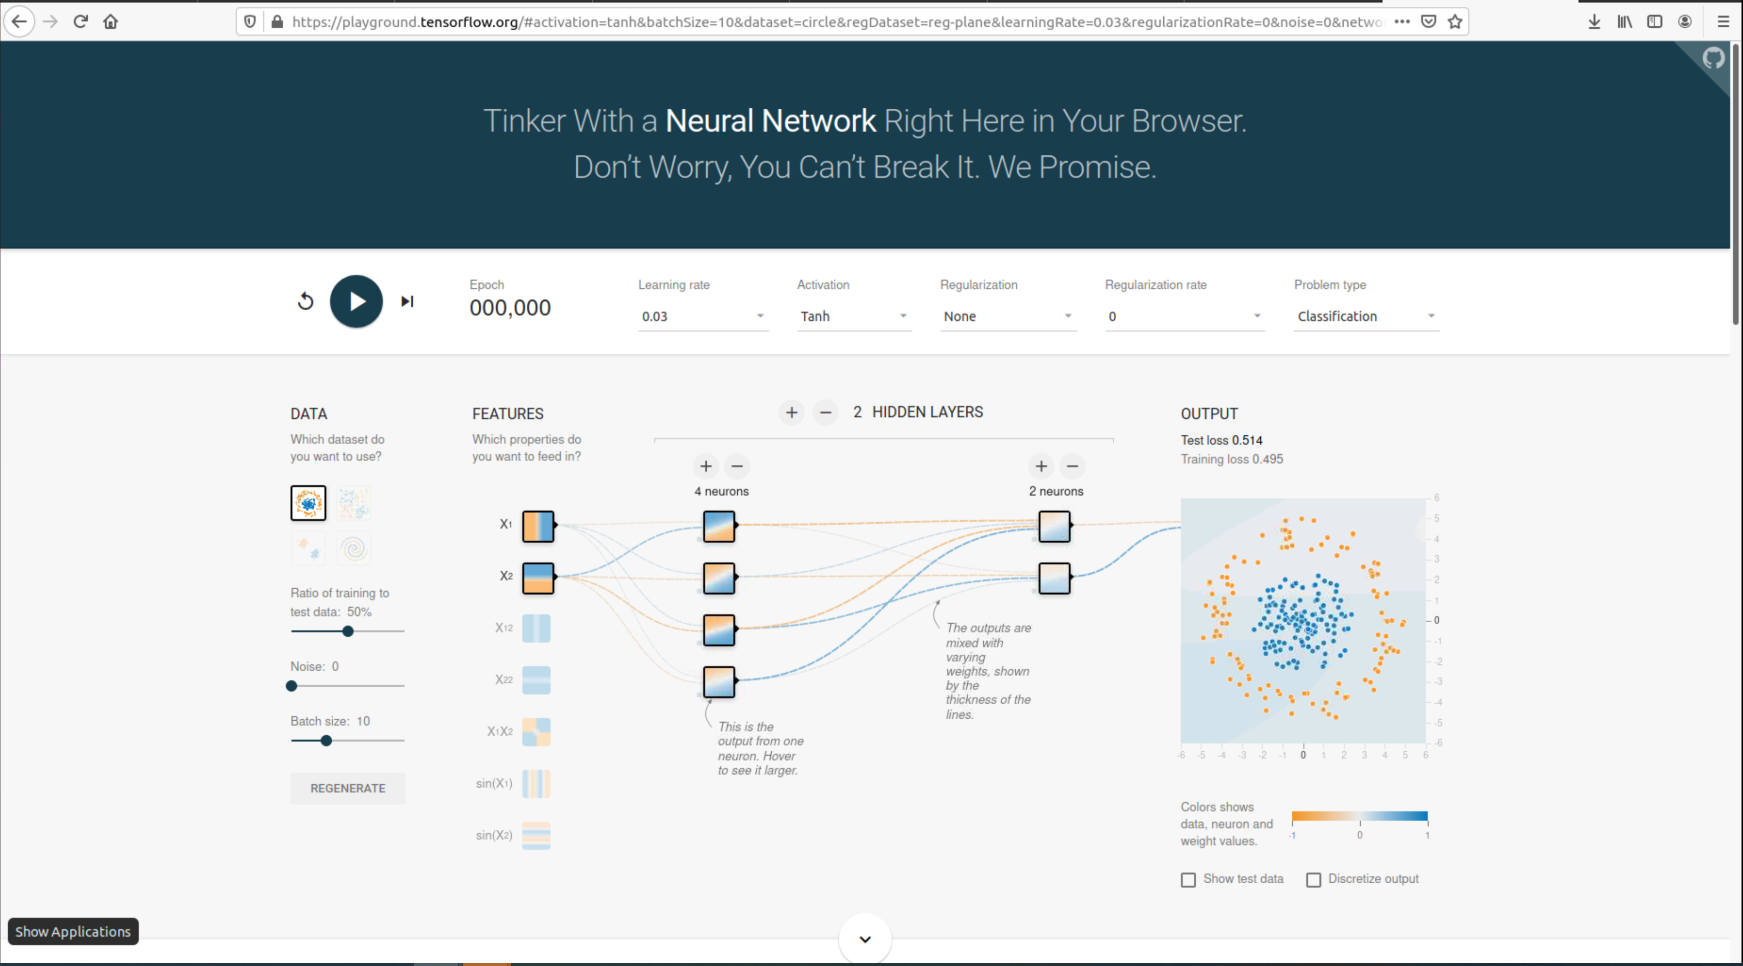

Set up a model with parameters (at the left) as:
- Ratio of training to test data: 90%
- Noise: 5
- Batch size: 4

Press "run" and observe the result. You can play around with the model.


## Exercise 1 (10 points)

In the Playground, select the spiral shape for the data
(the 4th shape). Set up parameters as follows.
- Ratio of training to test data: 90%
- Noise: 35
- Batch size: 4

Try to find a structure and parameters to find the best separation
between positive and negative cases. Capture a full screen result and input it in the next cell.

YOUR ANSWER HERE
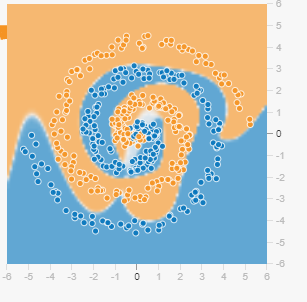



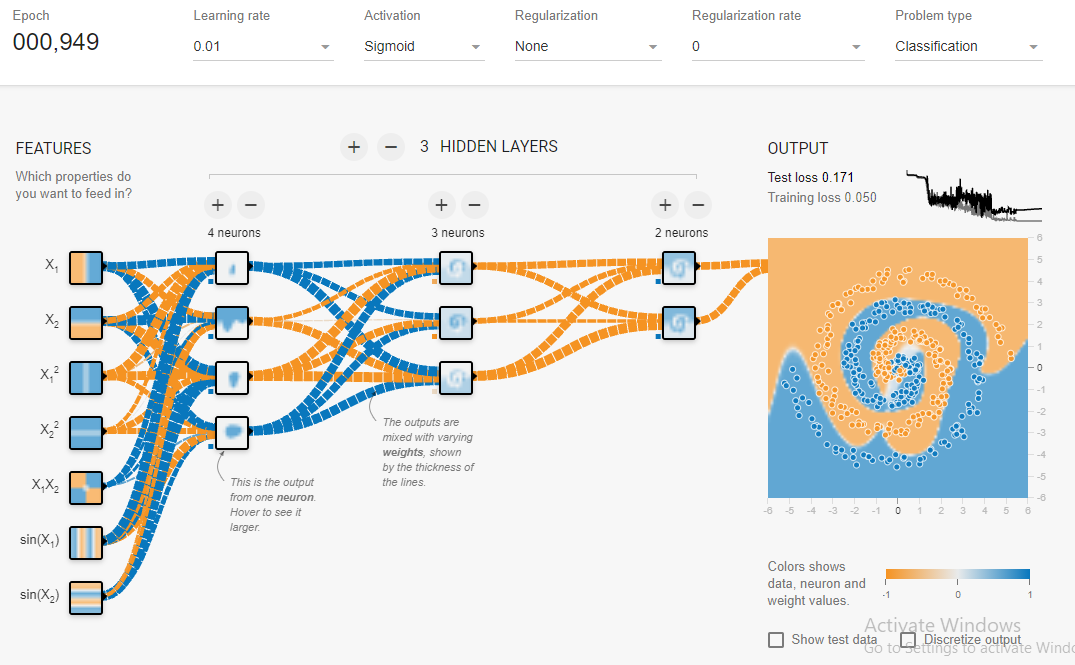


**Expected result**:

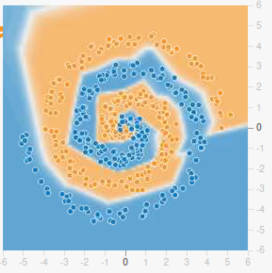

Let's make a GUI in Jupyter next (you GUI can also export to a HTML website).
Fix the settings to reflect what you did on the Playground.

In [3]:
# YOUR CODE HERE
#raise NotImplementedError()
from IPython.display import display, Markdown, clear_output

# Use the widget package
import ipywidgets as widgets

# Define some widgets
lblQ1 = widgets.Label(
        value="Q1) What is your learning rate?")
rdoQ1 = widgets.RadioButtons(
        options=['0.00001', '0.0001', '0.001', '0.003', '0.01', '0.03', '0.1', '0.3', '1', '3', '10',],
        value='0.03',
        description='\t',
        disabled=False)

lblQ2 = widgets.Label(
        value="Q2) What is your activation function in last layer?")
rdoQ2 = widgets.RadioButtons(
        options=['ReLu', 'Tanh', 'Sigmoid', 'Linear',],
        value='Tanh',
        description='\t',
        disabled=False)

lblQ3 = widgets.Label(
        value="Q3) What is problem type?")
rdoQ3 = widgets.RadioButtons(
        options=['Classification', 'Regression'],
        value='Classification',
        description='\t',
        disabled=False)

lblQ4 = widgets.Label(value="Q4) Which input do you use?")
chkQ4_1 = widgets.Checkbox(
           description='$X_1$',
           value=True)
chkQ4_2 = widgets.Checkbox(
           description='$X_2$',
           value=True)
chkQ4_3 = widgets.Checkbox(
           description='$X_1^2$',)
chkQ4_4 = widgets.Checkbox(
           description='$X_1X_2$',)
chkQ4_5 = widgets.Checkbox(
           description='$X_2^2$',)
chkQ4_6 = widgets.Checkbox(
           description='sin$(X_1)$',)
chkQ4_7 = widgets.Checkbox(
           description='sin$(X_2)$',)
chkQ4 = widgets.VBox([chkQ4_1, chkQ4_2, chkQ4_3, chkQ4_4, chkQ4_5, chkQ4_6, chkQ4_7])

lblQ5 = widgets.Label(value="Q5) How many hidden layers do you use?")
txtQ5 = widgets.IntText(
       value=0,
       description='hidden layers', )

lblQ6 = widgets.Label(value="Q6) Explain your nodes for each layer")
txtQ6 = widgets.Textarea(
       value='',
       description='Explain here', )

box = widgets.VBox([lblQ1, rdoQ1, lblQ2, rdoQ2, lblQ3, rdoQ3, lblQ4, chkQ4, lblQ5, txtQ5, lblQ6, txtQ6,])

box

In [4]:
q4str = ""
if chkQ4_1.value:
    q4str += " X1,"
if chkQ4_2.value:
    q4str += " X2,"
if chkQ4_3.value:
    q4str += " X1^2,"
if chkQ4_4.value:
    q4str += " X1X2,"
if chkQ4_5.value:
    q4str += " X2^2,"
if chkQ4_6.value:
    q4str += " sin(X1),"
if chkQ4_7.value:
    q4str += " sin(X2),"
print("Use input features:", q4str)
print("Problem type:", rdoQ3.value)
print("The last activation function:", rdoQ2.value)
print("Learning rate:", rdoQ1.value)
print("Use", txtQ5.value, "hidden layers. Each layer contains", txtQ6.value)

Use input features:  X1, X2,
Problem type: Classification
The last activation function: Tanh
Learning rate: 0.03
Use 0 hidden layers. Each layer contains 


## MNIST data set

An image is a 2D array of pixels. Pixels can be scalar intensities (for a grayscale / black and white image) or
a vector indicating a point in a color space such as RGB or HSV.

Today we'll consider 8$\times$8 grayscale images of digits from the famous "MNIST" dataset, which was considered
a benchmark for machine learning algorithms up to the early 2000s, before the advent of large-scale image
classification datasets.

MNIST is part of the SciKit-Learn module and has 10 classes,
with 180 samples per class in most cases, for a total of 1797 samples.

Let's load the dataset and plot an example.

Text(0.5, 1.0, 'Example MNIST sample (category 0)')

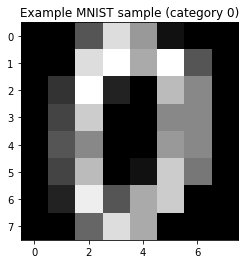

In [6]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

# Load data

data = load_digits()

def convert_to_one_hot(y):
    y_vect = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vect[i, int(y[i])] = 1
    return y_vect

# Convert target indices to one-hot representation

y_indices = data.target
y = convert_to_one_hot(y_indices)
X = np.matrix(data.data)
M = X.shape[0]
N = X.shape[1]

# Plot an example

plt.imshow(np.reshape(X[0,:],(8,8)), 'gray')
plt.title('Example MNIST sample (category %d)' % y_indices[0])

## Hand-Coded Fully Connected Neural Network

OK, now let's develop some code based on the mathematics we developed in
class to work with this dataset and run 100 epochs of training.
The main change is to use a one-hot encoding of the 10 classes at the output layer and to use
the softmax activation function at the output. Some minor changes are required to calculate multinomial
cross entropy loss rather than binary cross entropy loss.

First, some imports.

In [7]:
import random
import warnings
warnings.filterwarnings("ignore")

Next, let's normalize the input features using z-scaling (subtracting the mean of each input then dividing by
its standard deviation).

In [8]:
def normalize(X):
    M = X.shape[0]
    XX = X - np.tile(np.mean(X,0),[M,1])
    XX = np.divide(XX, np.tile(np.std(XX,0),[M,1]))
    return np.nan_to_num(XX, copy=True,nan=0.0)

XX = normalize(X)

Note that some researchers that do deep learning with
images use the word "normalization" to specifically indicate dividing
pixel intensities by 255 in order to scale them to the range 0..1. We use the more general
sense of the word "normalize," and we use the specific normalization technique of z-scaling.

Next we'll partition the data into separate training and test datasets.

In [9]:
idx = np.arange(0,M)

random.shuffle(idx)
percent_train = .6
m_train = int(M * percent_train)
train_idx = idx[:m_train]
test_idx = idx[m_train:]
X_train = XX[train_idx,:];
X_test = XX[test_idx,:];

y_train = y[train_idx];
y_test = y[test_idx];
y_test_indices = y_indices[test_idx]

Next, let's define a 3-layer network with sigmoid activation functions,
6 units in layer 1, and 5 units in layer 2.

In [25]:
h2 = 5
h1 = 6
num_class = len(set(y_test_indices))
W = [[], np.random.normal(0, 0.1, [N, h1]),
         np.random.normal(0, 0.1, [h1, h2]),
         np.random.normal(0, 0.1, [h2, num_class])]
b = [[], np.random.normal(0, 0.1, [h1, 1]),
         np.random.normal(0, 0.1, [h2, 1]),
         np.random.normal(0, 0.1, [num_class, 1])]
L = len(W) - 1


In [26]:
(W[1][0])

array([ 0.12006027, -0.03709938, -0.02491548, -0.10825867,  0.10710468,
        0.00270037])

Next, let's create some important functions used later.

In [27]:
def sigmoid_act(z):
    return 1 / (1 + np.exp(-z))

def softmax_act(z):
    exps = np.exp(z)
    return exps / np.sum(exps)

def sigmoid_actder(z):
    az = sigmoid_act(z)
    prod = np.multiply(az, 1 - az)
    return prod

def ff(x, W, b):
    L = len(W)-1
    a = x
    for l in range(1, L + 1): #range is exclusive of end
        z = W[l].T * a + b[l]
        if (l == L):
            a = softmax_act(z)
        else:
            a = sigmoid_act(z)
    return a

def loss(y, yhat):
    return - np.dot(y, np.log(yhat))

def forward(x_this, W, b):
    L = len(W) - 1
    a = [x_this]
    z = [[]]
    delta = [[]]
    dW = [[]]
    db = [[]]
    for l in range(1, L + 1):
        z.append(W[l].T * a[l-1] + b[l])
        if (l == L):
            a.append(softmax_act(z[l]))
        else:
            a.append(sigmoid_act(z[l]))
        # Just to give arrays the right shape for the backprop step
        delta.append([]); dW.append([]); db.append([])
    return a, z, delta, dW, db

def back_propagation(y_this, a, z, W,delta, dW, db, show_check=False):
    '''
    Backprop step. Note that derivative of multinomial cross entropy
    loss is the same as that of binary cross entropy loss. See
    https://levelup.gitconnected.com/killer-combo-softmax-and-cross-entropy-5907442f60ba
    for a nice derivation.
    '''
    L = len(W) - 1
    delta[L] = a[L] - np.matrix(y_this).T
    for l in range(L, 0, -1):
        db[l] = delta[l].copy()
        dW[l] = a[l-1] * delta[l].T
        if l > 1:
            delta[l-1] = np.multiply(sigmoid_actder(z[l-1]), W[l] * delta[l])

    # Check delta calculation

    if show_check:
        print('Target: %f' % y_this)
        print('y_hat: %f' % a[L][0, 0])
        print(db)
        y_pred = ff(x_this,W,b)
        diff = 1e-3
        W[1][10, 0] = W[1][10, 0] + diff
        y_pred_db = ff(x_this,W,b)
        L1 = loss(y_this, y_pred)
        L2 = loss(y_this, y_pred_db)
        db_finite_difference = (L2 - L1) / diff
        print('Original out %f, perturbed out %f' %
             (y_pred[0, 0], y_pred_db[0, 0]))
        print('Theoretical dW %f, calculated db %f' %
              (dW[1][10, 0], db_finite_difference[0, 0]))
    return dW, db

def update_step(W, b, dW, db, alpha):
    L = len(W) - 1
    for l in range(1, L + 1):            
        W[l] = W[l] - alpha * dW[l]
        b[l] = b[l] - alpha * db[l]
    return W, b

Now, let's train for 100 epochs with a mini-batch size of 1.

In [28]:
cost_arr = [] 

alpha = 0.01
max_iter = 100
for iter in range(0, max_iter):
    loss_this_iter = 0
    order = np.random.permutation(m_train)
    for i in range(0, m_train):
        
        # Grab the pattern order[i]
        
        x_this = X_train[order[i],:].T
        y_this = y_train[order[i],:]

        # Feed forward step
        a, z, delta, dW, db = forward(x_this, W, b)
            
        # calulate loss
        loss_this_pattern = loss(y_this, a[L])
        loss_this_iter = loss_this_iter + loss_this_pattern
        
        # back propagation
        dW, db = back_propagation(y_this, a, z, W,delta, dW, db, show_check=False)
        
        # update weight, bias
        W, b = update_step(W, b, dW, db, alpha)
            
    cost_arr.append(loss_this_iter[0,0])
    print('Epoch %d train loss %f' % (iter, loss_this_iter))

Epoch 0 train loss 2491.326570
Epoch 1 train loss 2487.777784
Epoch 2 train loss 2485.774415
Epoch 3 train loss 2484.857207
Epoch 4 train loss 2485.119119
Epoch 5 train loss 2483.114393
Epoch 6 train loss 2479.758757
Epoch 7 train loss 2476.323937
Epoch 8 train loss 2470.174532
Epoch 9 train loss 2456.732231
Epoch 10 train loss 2430.140784
Epoch 11 train loss 2384.018362
Epoch 12 train loss 2304.231811
Epoch 13 train loss 2198.698083
Epoch 14 train loss 2094.029284
Epoch 15 train loss 2006.448510
Epoch 16 train loss 1934.417964
Epoch 17 train loss 1865.698618
Epoch 18 train loss 1801.279496
Epoch 19 train loss 1726.219510
Epoch 20 train loss 1649.541969
Epoch 21 train loss 1570.070280
Epoch 22 train loss 1494.492928
Epoch 23 train loss 1424.337539
Epoch 24 train loss 1360.541303
Epoch 25 train loss 1300.080258
Epoch 26 train loss 1245.911106
Epoch 27 train loss 1196.175502
Epoch 28 train loss 1148.589165
Epoch 29 train loss 1100.820412
Epoch 30 train loss 1058.765753
Epoch 31 train los

Let's plot the loss over time per epoch.

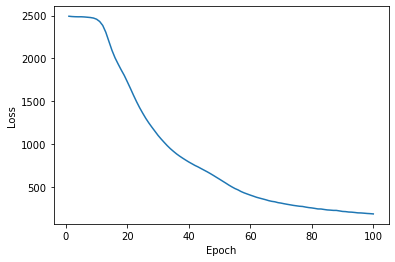

In [29]:
plt.plot(np.arange(1, max_iter + 1, 1), cost_arr)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Let's get the test set accuracy.

In [30]:
def predict_y(W, b, X):
    M = X.shape[0]
    y_pred = np.zeros(M)
    for i in range(X.shape[0]):
        y_pred[i] = np.argmax(ff(X[i, :].T, W, b))
    return y_pred

y_test_predicted = predict_y(W, b, X_test)
y_correct = y_test_predicted == y_test_indices
test_accuracy = np.sum(y_correct) / len(y_correct)

print('Test accuracy: %.4f' % (test_accuracy))

Test accuracy: 0.8846


## In-class exercise (40 points)

Modify the code above to plot both training loss and test loss as a function of epoch number.
Use early stopping to obtain the best model according to the validation set.
Experiment with the hyperparameters (learning rate, number of layers, number of units per layer) to get
the best result you can. In the cell below,
- Train with at least three different hyperparameter sets.
- Plot loss curves for the training and test sets on the same graph, with a legend showing the different
  hyperparameter settings.
- For each set of parameters, give the best validation accuracy.
- Describe your experiments and results below the code.

In [31]:
#Reupdating values of W and b
h2 = 5
h1 = 6
num_class = len(set(y_test_indices))
W = [[], np.random.normal(0, 0.1, [N, h1]),
         np.random.normal(0, 0.1, [h1, h2]),
         np.random.normal(0, 0.1, [h2, num_class])]
b = [[], np.random.normal(0, 0.1, [h1, 1]),
         np.random.normal(0, 0.1, [h2, 1]),
         np.random.normal(0, 0.1, [num_class, 1])]
L = len(W) - 1

In [32]:
cost_arr1 = [] 
test_cost_arr1 = []

alpha = 0.01
max_iter = 100

best_cost= np.inf
W_star = W
b_star = b
best_iter = 1

for iter in range(0, max_iter):
    loss_this_iter = 0
    test_loss = 0
    order = np.random.permutation(m_train)
    for i in range(0, m_train):
        
        # Grab the pattern order[i]
        
        x_this = X_train[order[i],:].T
        y_this = y_train[order[i],:]

        # Feed forward step
        a, z, delta, dW, db = forward(x_this, W, b)
            
        # calulate loss
        loss_this_pattern = loss(y_this, a[L])
        loss_this_iter = loss_this_iter + loss_this_pattern
        
        # back propagation
        dW, db = back_propagation(y_this, a, z, W,delta, dW, db, show_check=False)
        
        # update weight, bias
        W, b = update_step(W, b, dW, db, alpha)
    
    
    y_pred = np.zeros((X_test.shape[0]))
                          
    for k in range(X_test.shape[0]):
        y_pred = ff(X_test[k,:].T, W, b)
        test_loss += loss(y_test[k], y_pred)
   
    
    test_cost_arr1.append(test_loss[0,0]) 
    cost_arr1.append(loss_this_iter[0,0])
    
    if test_loss < best_cost:
        best_cost = test_loss
        W_star = W.copy()
        b_star = b.copy()
        best_iter = iter
    
    
    if iter %20 == 0:
        print('Epoch %d train loss %f and Test Loss %f' % (iter, loss_this_iter,test_loss))
        
print('Best cost %f is at %f iteration '% (best_cost,best_iter))

y_test_predicted = predict_y(W_star, b_star, X_test)
y_correct = y_test_predicted == y_test_indices
test_accuracy1 = np.sum(y_correct) / len(y_correct)

print('Best Test accuracy: %.4f' % (test_accuracy1))

Epoch 0 train loss 2492.360191 and Test Loss 1663.783774
Epoch 20 train loss 1758.743841 and Test Loss 1174.598784
Epoch 40 train loss 845.658949 and Test Loss 630.386831
Epoch 60 train loss 378.868840 and Test Loss 360.785439
Epoch 80 train loss 222.859682 and Test Loss 296.139424
Best cost 275.384023 is at 99.000000 iteration 
Best Test accuracy: 0.8887


In [33]:
#Reupdating values of W and b
#Model 2 with new hyperparameters
#New values of h2 = 6, h1 = 5 , alpha = 0.05
h2 = 6
h1 = 5
num_class = len(set(y_test_indices))
W = [[], np.random.normal(0, 0.1, [N, h1]),
         np.random.normal(0, 0.1, [h1, h2]),
         np.random.normal(0, 0.1, [h2, num_class])]
b = [[], np.random.normal(0, 0.1, [h1, 1]),
         np.random.normal(0, 0.1, [h2, 1]),
         np.random.normal(0, 0.1, [num_class, 1])]
L = len(W) - 1

alpha = 0.05
max_iter = 100

best_cost= np.inf
W_star = W
b_star = b
best_iter = 1

In [34]:
cost_arr2 = [] 
test_cost_arr2 = []

for iter in range(0, max_iter):
    loss_this_iter = 0
    test_loss = 0
    order = np.random.permutation(m_train)
    for i in range(0, m_train):
        
        # Grab the pattern order[i]
        
        x_this = X_train[order[i],:].T
        y_this = y_train[order[i],:]

        # Feed forward step
        a, z, delta, dW, db = forward(x_this, W, b)
            
        # calulate loss
        loss_this_pattern = loss(y_this, a[L])
        loss_this_iter = loss_this_iter + loss_this_pattern
        
        # back propagation
        dW, db = back_propagation(y_this, a, z, W,delta, dW, db, show_check=False)
        
        # update weight, bias
        W, b = update_step(W, b, dW, db, alpha)
    
    
    y_pred = np.zeros((X_test.shape[0]))
                          
    for k in range(X_test.shape[0]):
        y_pred = ff(X_test[k,:].T, W, b)
        test_loss += loss(y_test[k], y_pred)
     
    test_cost_arr2.append(test_loss[0,0])            
    cost_arr2.append(loss_this_iter[0,0])
    
    if test_loss < best_cost:
        best_cost = test_loss
        W_star = W.copy()
        b_star = b.copy()
        best_iter = iter
    
    
    if iter %20 == 0:
        print('Epoch %d train loss %f and Test Loss %f' % (iter, loss_this_iter,test_loss))
        
        
print('Best cost %f is at %f iteration '% (best_cost,best_iter))        
y_test_predicted = predict_y(W_star, b_star, X_test)
y_correct = y_test_predicted == y_test_indices
test_accuracy2 = np.sum(y_correct) / len(y_correct)

print('Best Test accuracy: %.4f' % (test_accuracy2))

Epoch 0 train loss 2515.650929 and Test Loss 1663.569917
Epoch 20 train loss 252.113809 and Test Loss 283.350921
Epoch 40 train loss 154.588829 and Test Loss 299.721041
Epoch 60 train loss 79.266082 and Test Loss 323.046257
Epoch 80 train loss 78.616024 and Test Loss 342.441739
Best cost 262.704613 is at 18.000000 iteration 
Best Test accuracy: 0.9013


In [35]:
#Reupdating values of W and b
#Model 2 with new hyperparameters
#New values of h2 = 7, h1 = 8 , alpha = 0.1
h2 = 7
h1 = 8
num_class = len(set(y_test_indices))
W = [[], np.random.normal(0, 0.1, [N, h1]),
         np.random.normal(0, 0.1, [h1, h2]),
         np.random.normal(0, 0.1, [h2, num_class])]
b = [[], np.random.normal(0, 0.1, [h1, 1]),
         np.random.normal(0, 0.1, [h2, 1]),
         np.random.normal(0, 0.1, [num_class, 1])]
L = len(W) - 1

alpha = 0.1
max_iter = 100

best_cost= np.inf
W_star = W
b_star = b
best_iter = 1

In [36]:
cost_arr3 = [] 
test_cost_arr3 = []

for iter in range(0, max_iter):
    loss_this_iter = 0
    test_loss = 0
    order = np.random.permutation(m_train)
    for i in range(0, m_train):
        
        # Grab the pattern order[i]
        
        x_this = X_train[order[i],:].T
        y_this = y_train[order[i],:]

        # Feed forward step
        a, z, delta, dW, db = forward(x_this, W, b)
            
        # calulate loss
        loss_this_pattern = loss(y_this, a[L])
        loss_this_iter = loss_this_iter + loss_this_pattern
        
        # back propagation
        dW, db = back_propagation(y_this, a, z, W,delta, dW, db, show_check=False)
        
        # update weight, bias
        W, b = update_step(W, b, dW, db, alpha)
    
    
    y_pred = np.zeros((X_test.shape[0]))
                          
    for k in range(X_test.shape[0]):
        y_pred = ff(X_test[k,:].T, W, b)
        test_loss += loss(y_test[k], y_pred)
        
    if test_loss < best_cost:
        best_cost = test_loss
        W_star = W.copy()
        b_star = b.copy()
        best_iter = iter
     
    test_cost_arr3.append(test_loss[0,0])            
    cost_arr3.append(loss_this_iter[0,0])
    if iter %20 == 0:
        print('Epoch %d train loss %f and Test Loss %f' % (iter, loss_this_iter,test_loss))
        
print('Best cost %f is at %f iteration '% (best_cost,best_iter))        
y_test_predicted = predict_y(W_star, b_star, X_test)
y_correct = y_test_predicted == y_test_indices
test_accuracy3 = np.sum(y_correct) / len(y_correct)

print('Best Test accuracy: %.4f' % (test_accuracy3))

Epoch 0 train loss 2513.338330 and Test Loss 1620.324860
Epoch 20 train loss 61.413784 and Test Loss 222.659739
Epoch 40 train loss 31.564232 and Test Loss 226.868013
Epoch 60 train loss 22.228517 and Test Loss 222.081422
Epoch 80 train loss 18.421423 and Test Loss 248.097591
Best cost 199.488313 is at 21.000000 iteration 
Best Test accuracy: 0.9388


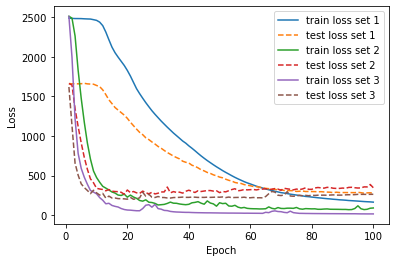

In [37]:
plt.plot(np.arange(1, max_iter + 1, 1), cost_arr1, label='train loss set 1')
plt.plot(np.arange(1, max_iter + 1, 1), test_cost_arr1,'--', label='test loss set 1')
plt.plot(np.arange(1, max_iter + 1, 1), cost_arr2, label='train loss set 2')
plt.plot(np.arange(1, max_iter + 1, 1), test_cost_arr2,'--', label='test loss set 2')
plt.plot(np.arange(1, max_iter + 1, 1), cost_arr3, label='train loss set 3')
plt.plot(np.arange(1, max_iter + 1, 1), test_cost_arr3,'--', label='test loss set 3')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [38]:
print('The best accuracies of the models 3 ,2 and 1 are as follows \n',test_accuracy3, test_accuracy2, test_accuracy1)

The best accuracies of the models 3 ,2 and 1 are as follows 
 0.9388038942976356 0.9012517385257302 0.8887343532684284


### Hyperparameters sets
Set 1 h2 = 5, h1 = 6, alpha = 0.01

Set 2 h2 = 6, h1 = 5, alpha = 0.05

Set 3 h2 = 7, h1 = 8, alpha = 0.1

It appears the set 3 with h2 = 7, h1 = 8 , alpha = 0.1 performs the best. All Test loss starts to increase slightly after a certain iteration. The best test accuracy for set 3 is actually at the 14th iteration. Increasing the number of hidden layers seems to make the model perform better but also seems to overfit after a certain iterations. Like in set 3 after the 14th iteration the test set loss starts to increase slowly.

The rest of the hyperparameter sets also exhibit similar behaviour. Although they take more time to reach a good accuracy, within 100 iterations all models have a loss of less than 500 in the test set.


## PyTorch tutorial

Is there an easier way to build this type of model? One way is to learn a framework such as TensorFlow or PyTorch. Both of these frameworks have their
pros and cons, but PyTorch is probably the most productive neural network framework for research purposes. We'll use it here.

The material for this tutorial is from
[Anand Saha's PyTorch tutorial](https://github.com/anandsaha/deep.learning.with.pytorch).

### Tensors and Tensor operations

Let's get some hands on experience with tensor creation and operations.
The torch package contains the necessary data structures to create multidimensional tensors.
It also defines the mathematical operations that can be performed on these.

In [22]:
import torch

print('Torch version:', torch.__version__)
print('Torch+CUDA working:', torch.cuda.is_available())

Torch version: 1.4.0
Torch+CUDA working: True


#### Tensor creation

Let's create a (2$\times$3) (two-dimensional) tensor.

Note that a) you get back a FloatTensor, and  b) the values are uninitialized.

In [23]:
t = torch.Tensor(2, 3)
print(t)

tensor([[0., 0., 0.],
        [0., 0., 0.]])


The above call was equivalent to

In [24]:
t = torch.FloatTensor(2, 3)
print(t)

tensor([[ 7.6878e-25,  4.5901e-41, -1.5441e-02],
        [ 3.0627e-41,  4.4842e-44,  0.0000e+00]])


We can access an element, get an element's type, and get the shape of the tensor:

In [25]:
print('Elmement 0,0 of t:', t[0,0])
print('Type of element 0,0 of t:', type(t[0,0]))
print('Size of t:', t.size())
print('Number of dimensions in t:', t.dim())
print('A tensor\'s length is the number of dimensions it has?', len(t.size()) == t.dim())

Elmement 0,0 of t: tensor(7.6878e-25)
Type of element 0,0 of t: <class 'torch.Tensor'>
Size of t: torch.Size([2, 3])
Number of dimensions in t: 2
A tensor's length is the number of dimensions it has? True


Let's set some of the elements of the the tensor to various values:

In [26]:
t[0][0] = 1
t[0][1] = 2
t[0][2] = 3
t[1][0] = 4
t[1][1] = 5
t[1][2] = 6
print(t)

tensor([[1., 2., 3.],
        [4., 5., 6.]])


A `FloatTensor` can be cast to an `IntTensor`:

In [27]:
t = torch.FloatTensor([1.1, 2.2])
print('Float tensor:', t)
print('Int tensor:', t.type(torch.IntTensor))

Float tensor: tensor([1.1000, 2.2000])
Int tensor: tensor([1, 2], dtype=torch.int32)


Let's explore some other ways of creating a tensor.

In [28]:
# From another Tensor

t2 = torch.Tensor(t)
print('From a tensor:', t2)

# From a Python list

t3 = torch.IntTensor([[1, 2], [3, 4]])
print('From a Python list:', t3)

# From a NumPy array

import numpy as np
a = np.array([55, 66])
t4 = torch.Tensor(a)
print('From a NumPy array:', t4)

# A tensor with all zeros

t5 = torch.zeros(2, 3)
print('A tensor with all zeros:', t5)

# Create a tensor with all ones

t6 = torch.ones(2, 3)
print('A tensor with all ones:', t6)

# Create a tensor with all ones with dimensions 
# of another tensor

t7 = torch.ones_like(t4)
print('Another tensor of ones, with shape like another:', t7)

From a tensor: tensor([1.1000, 2.2000])
From a Python list: tensor([[1, 2],
        [3, 4]], dtype=torch.int32)
From a NumPy array: tensor([55., 66.])
A tensor with all zeros: tensor([[0., 0., 0.],
        [0., 0., 0.]])
A tensor with all ones: tensor([[1., 1., 1.],
        [1., 1., 1.]])
Another tensor of ones, with shape like another: tensor([1., 1.])


#### Tensor operations

Let's experiment with operations on tensors. We can add tensors of the same shape:

In [29]:
t1 = torch.ones(2, 2)
t2 = torch.ones(2, 2)
t = t1 + t2
print(t)
print(t1)

tensor([[2., 2.],
        [2., 2.]])
tensor([[1., 1.],
        [1., 1.]])


Here are some examples of in-place and out-of-place operations.

In [30]:
t1.add(t2)

tensor([[2., 2.],
        [2., 2.]])

In [31]:
print(t1)

tensor([[1., 1.],
        [1., 1.]])


In [32]:
t1.add_(t2)

tensor([[2., 2.],
        [2., 2.]])

In [33]:
print(t1)

tensor([[2., 2.],
        [2., 2.]])


Many operations are implemented as both instance methods and as library/package functions:

In [34]:
t1.cos()

tensor([[-0.4161, -0.4161],
        [-0.4161, -0.4161]])

In [35]:
torch.cos(t1)

tensor([[-0.4161, -0.4161],
        [-0.4161, -0.4161]])

A few more operations

In [36]:
# Create a one-dimensional tensor of steps equally 
# spaced points between start and end

torch.linspace(3, 10, steps=5)

tensor([ 3.0000,  4.7500,  6.5000,  8.2500, 10.0000])

In [37]:
# Create a 1-D Tensor with values from [start, end)

torch.arange(0, 5)

tensor([0, 1, 2, 3, 4])

In [38]:
# Create a (2x3) Tensor with random values sampled 
# from uniform distrubution on the interval [0,1)

torch.rand((2,3))

tensor([[0.3646, 0.7522, 0.1319],
        [0.6582, 0.0767, 0.4056]])

In [39]:
# Create a (2x3) Tensor with random values sampled 
# from normal distrubution with 0 mean and variance 1

torch.randn((2,3))

tensor([[ 0.6730, -1.1134,  0.2470],
        [-1.3123,  0.0507,  1.0697]])

In [40]:
# Do a matrix multiply

a = torch.rand((2, 3))
b = torch.rand((3, 2))

torch.mm(a, b)

tensor([[0.8985, 0.7808],
        [0.4333, 0.9333]])

#### Variables

Next, let's understand variables in PyTorch and the operations we can perform on them.

In [41]:
import torch
from torch.autograd import Variable

Let's create a small computation graph

In [42]:
x = Variable(torch.FloatTensor([11.2]), requires_grad=True)
y = 2 * x

In [43]:
print(x)
print(y)

tensor([11.2000], requires_grad=True)
tensor([22.4000], grad_fn=<MulBackward0>)


In [44]:
print(x.data)
print(y.data)

tensor([11.2000])
tensor([22.4000])


In [45]:
print(x.grad_fn)
print(y.grad_fn)

None


In [46]:
y.backward() # Calculates the gradients

In [47]:
print(x.grad)
print(y.grad)

tensor([2.])
None


### Working with PyTorch and NumPy

In [48]:
import torch
import numpy as np

Convert a NumPy array to Tensor

In [49]:
n = np.array([2, 3])
t = torch.from_numpy(n)
print(n)
print(t)

[2 3]
tensor([2, 3])


Change a Tensor value, and see the change in 
corresponding NumPy array

In [50]:
n[0] = 100
print(t)

tensor([100,   3])


Convert a Tensor to NumPy array

In [51]:
t = torch.FloatTensor([5, 6])
n = t.numpy()
print(t)
print(n)

tensor([5., 6.])
[5. 6.]


Change a Tensor value, and see the change in corresponding NumPy array

In [52]:
t[0] = 100
print(n)

[100.   6.]


### Tensors on GPU

Check if your machine has GPU support

In [53]:
if torch.cuda.is_available():
    print("GPU Supported")
else:
    print("GPU Not Supported")

GPU Supported


Check the number of GPUs attached to this machine

In [54]:
torch.cuda.device_count()

4

Get device name

In [55]:
torch.cuda.get_device_name(0)

'GeForce RTX 2080 Ti'

Moving a Tensor to GPU

In [56]:
t = torch.FloatTensor([2, 3])

In [57]:
print(t)

tensor([2., 3.])


In [58]:
t = t.cuda(0)

Creating a Tensor on GPU, directly

In [59]:
t = torch.cuda.FloatTensor([2, 3])
print(t)

tensor([2., 3.], device='cuda:0')


Bring it back to CPU

In [60]:
t = t.cpu()
print(t)

tensor([2., 3.])


Use device context

In [61]:
with torch.cuda.device(0):
    t = torch.cuda.FloatTensor([2, 3])
    print(t)

tensor([2., 3.], device='cuda:0')



## MNIST digit recognition using PyTorch

This part of the lab was
taken from the [Kaggle tutorial on MNIST with PyTorch]('https://www.kaggle.com/justuser/mnist-with-pytorch-fully-connected-network).

We will use a fully connected neural network and a batch learning algorithm and explain each
step along the way.

We need NumPy, PyTorch, some of PyTorch's modules, MatPlotLib, Seaborn for visualization, and pandas for
data import and transformations.

In [39]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

Now we can import and transform the data. I decided to split it into input and labels right away at this step:

In [40]:
print("Reading the data...")
data = pd.read_csv('train_mnist.csv', sep=",")
test_data = pd.read_csv('test_mnist.csv', sep=",")

print("Reshaping the data...")
dataFinal = data.drop('label', axis=1)
labels = data['label']


dataNp = dataFinal.to_numpy()
labelsNp = labels.to_numpy()
test_dataNp = test_data.to_numpy()

print("Data is ready")

Reading the data...
Reshaping the data...
Data is ready


Now that data is ready, we can take a look at what we're dealing with. I will be using heatmaps from seaborn, which is an excellent tool for matrix visualization. But first, since the images in the MNIST dataset are represented as a long 1d arrays of pixels, we will need to reshape it into 2d array. That's where .reshape() from numpy comes in handy. The pictures are 28 x 28 pixels, so these will be the parameters.

Let's select a couple random samples and visualize them. I will also print their labels, so we can compare images with their actual value:

8  /  9
8  /  4
9  /  1


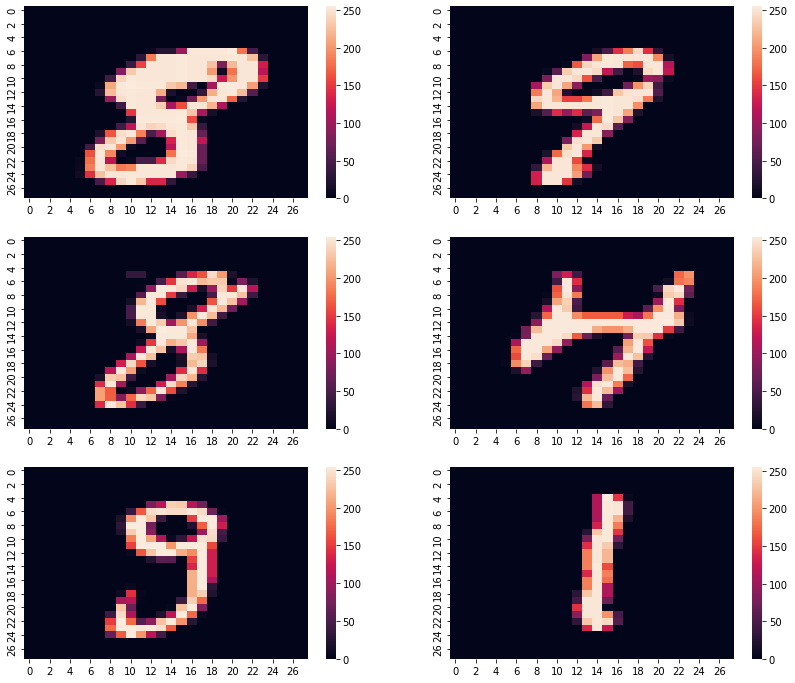

In [41]:
plt.figure(figsize=(14, 12))

pixels = dataNp[10].reshape(28, 28)
plt.subplot(321)
sns.heatmap(data=pixels)

pixels = dataNp[11].reshape(28, 28)
plt.subplot(322)
sns.heatmap(data=pixels)

pixels = dataNp[20].reshape(28, 28)
plt.subplot(323)
sns.heatmap(data=pixels)

pixels = dataNp[32].reshape(28, 28)
plt.subplot(324)
sns.heatmap(data=pixels)

pixels = dataNp[40].reshape(28, 28)
plt.subplot(325)
sns.heatmap(data=pixels)

pixels = dataNp[52].reshape(28, 28)
plt.subplot(326)
sns.heatmap(data=pixels)

print(labels[10], " / ", labels[11])
print(labels[20], " / ", labels[32])
print(labels[40], " / ", labels[52])

Since PyTorch uses tensors, we need to transform the input images
into tensors. The good news, as we saw earlier, is that PyTorch makes it very easy to move data from
NumPy arrays or regular Python lists to tensors. Here's how to do it for our data:

In [44]:
x = torch.FloatTensor(dataNp.tolist())
y = torch.LongTensor(labelsNp.tolist())

Before we start writing the actual network, we need to determine what will be the hyperparameters. Those will not be adjusted during training, so we need to be careful how we set them up. 

Here's what we will specify:
* **input_size** - size of the input layer, it is always fixed (784 pixels)
* **output_size** - size of the output layer, also fixed size (10 for every possible digit)
* **hidden_size** - size of the hidden layer, this parameter determines structure of the network. 200 worked for me, but it is worth to play with this parameter to see what works for you
* **epochs** - how many times will the network go through the entire dataset during training. 
* **learning_rate** - determines how fast will the network learn. You should be very careful about this parameter, because if it is too high, the network won't learn at all, if it is too low, the net will learn too long. I's always about balance. Usualy 10^-3 - 10^-5 works just fine.
* **batch_size** - size of mini batches during training

In [45]:
# hyperparameters
input_size = 784
output_size = 10
hidden_size = 200

epochs = 20
batch_size = 50
learning_rate = 0.00005

Now we can finally write a Python class for the actual network.
Our `Network` class will be a subclass of PyTorch's neural network
`Module` class.

When writing a PyTorch neural network class, a few things must always be there:
* `__init__(self)`: initializes the the new `Network` instance. Here we set up instance fields
  representing the parameters of the network as well as any other needed initialization.
* `forward(self, x)`: defines how an input is propagated forward through the various layers
  and transformations in the network. The forward function normally makes use of the instance
  fields set up in the initialization stage.

In the initialization, first of all, we need to initialize the superclass's fields then
create needed layers with parameters. You can experiment with this (put more layers or change hidden layer size, etc.), but the give structure will work fine.

In forward propagation, we simply reassign the value of `x` as it flows through the layers
and return the softmax of the last linear layer's values at the end.

In [46]:
class Network(nn.Module):
    
    def __init__(self):
        super(Network, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l3(x)
        return F.log_softmax(x)

After we've defined the network, we can initialize it. 
Also, if we "print" the instance of the net, we can see the structure of it in a neat format:

In [47]:
net = Network()
print(net)

Network(
  (l1): Linear(in_features=784, out_features=200, bias=True)
  (relu): ReLU()
  (l3): Linear(in_features=200, out_features=10, bias=True)
)


Now it's time to set up the [optimizer](http://pytorch.org/docs/master/optim.html) and a loss function. 

*There are quite a lot of things happening behind these two lines of code, so if you don't know what is going on here, don't worry too much for now, it will get clearer eventualy.* 

Optimizer is what  updates the parameters of the network. We'll use the most basic method, stochastic gradient descent with momentum. Also, the optimizer takes the network parameters as an argument, but it's not a big deal since we can get those with a `parameters()` method call on the network instance.

As is standard for a multinomial output distribution, we use [cross entropy loss](https://en.wikipedia.org/wiki/Cross_entropy).

In [48]:
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

Now that everything is ready, our network can start learning. I will separate data into minibatches and feed it to the network. It has many advantages over single batch learning, but that is a different story. 

Also, I will use loss_log list to keep track of the loss function during the training process. 

In [49]:
x.shape

torch.Size([42000, 784])

In [55]:
loss_log = []

for e in range(epochs):
    for i in range(0, x.shape[0], batch_size):
        x_mini = x[i:i + batch_size] 
        y_mini = y[i:i + batch_size] 
        
        x_var = Variable(x_mini)
        y_var = Variable(y_mini)
        
        optimizer.zero_grad()
        net_out = net(x_var)
        
        loss = loss_func(net_out, y_var)
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            loss_log.append(loss.item())
        
    print('Epoch: {} - Loss: {:.6f}'.format(e, loss.item()))

Epoch: 0 - Loss: 0.003528
Epoch: 1 - Loss: 0.003296
Epoch: 2 - Loss: 0.002908
Epoch: 3 - Loss: 0.002808
Epoch: 4 - Loss: 0.002491
Epoch: 5 - Loss: 0.002360
Epoch: 6 - Loss: 0.002205
Epoch: 7 - Loss: 0.002066
Epoch: 8 - Loss: 0.002011
Epoch: 9 - Loss: 0.001845
Epoch: 10 - Loss: 0.001793
Epoch: 11 - Loss: 0.001720
Epoch: 12 - Loss: 0.001682
Epoch: 13 - Loss: 0.001595
Epoch: 14 - Loss: 0.001553
Epoch: 15 - Loss: 0.001506
Epoch: 16 - Loss: 0.001467
Epoch: 17 - Loss: 0.001434
Epoch: 18 - Loss: 0.001390
Epoch: 19 - Loss: 0.001364


So, let's go line by line and see what is happening here:

This is the main loop that goes through all the epochs of training. An epoch is one full training on the full dataset.

    for e in range(epochs):
This is the inner loop that simply goes through the dataset batch by batch:

    for i in range(0, x.shape[0], batch_size):
Here is where we get the batches out of our data and simply assign them to variables for further work:

    x_mini = x[i:i + batch_size] 
    y_mini = y[i:i + batch_size] 
   These two lines are quite *important*. Remember I told you about tensors and how PyTorch stores data in them? That's not the end of story. Actually, to allow the network to work with data, we need a wrapper for those tensors called Variable. It has some additional properties, like allowing automatic gradient computation when backpropagating. It is required for the proper work of PyTorch, so we will add them here and supply tensors as parameters:
   
    x_var = Variable(x_mini)
    y_var = Variable(y_mini)
This line just resets the gradient of the optimizer:
    
    optimizer.zero_grad()
Remember the *forward(self, x)* function that we previously defined? The next line is basically calling this function and does the forward propagation:

    net_out = net(x_var)
This line computes the loss function based on predictions of the net and the correct answers:

    loss = loss_func(net_out, y_var)
Here we compute the gradient based on the loss that we've got. It will be used to adjust parameters of the network.

    loss.backward()
And here is where we finally update our network with new adjusted parameters:

    optimizer.step()
The rest is just logging, which might be helpful to observe how well the network is performing.

After the network is done with training, we can take a look at the loss function, and how it behaved during training:

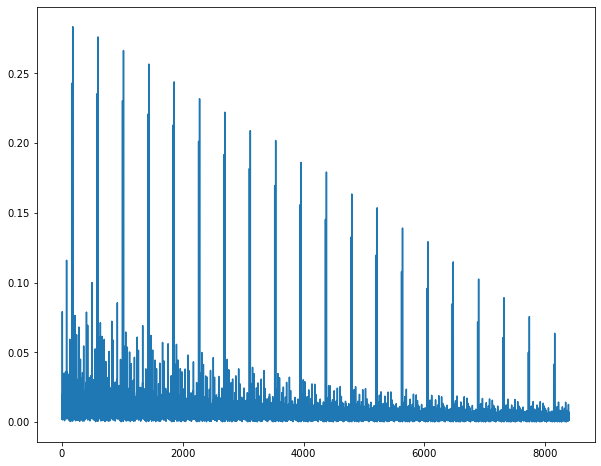

In [56]:
plt.figure(figsize=(10,8))
plt.plot(loss_log)

At this point, the network should be trained, and we can make a prediction using the test dataset. All we need to do is wrap the data into the Variable and feed it to the trained net, so nothing new here.

In [57]:
test = torch.FloatTensor(test_dataNp.tolist())
test_var = Variable(test)

net_out = net(test_var)

print(torch.max(net_out.data, 1)[1].numpy())

[2 0 9 ... 3 9 2]


Now we have out predictions that are ready to be submitted. Before that, we can take a look at predictions and compare them to the actual pictures of digits, just like at the start with training data:

Prediction: 0 / 5
Prediction: 9 / 7
Prediction: 0 / 8


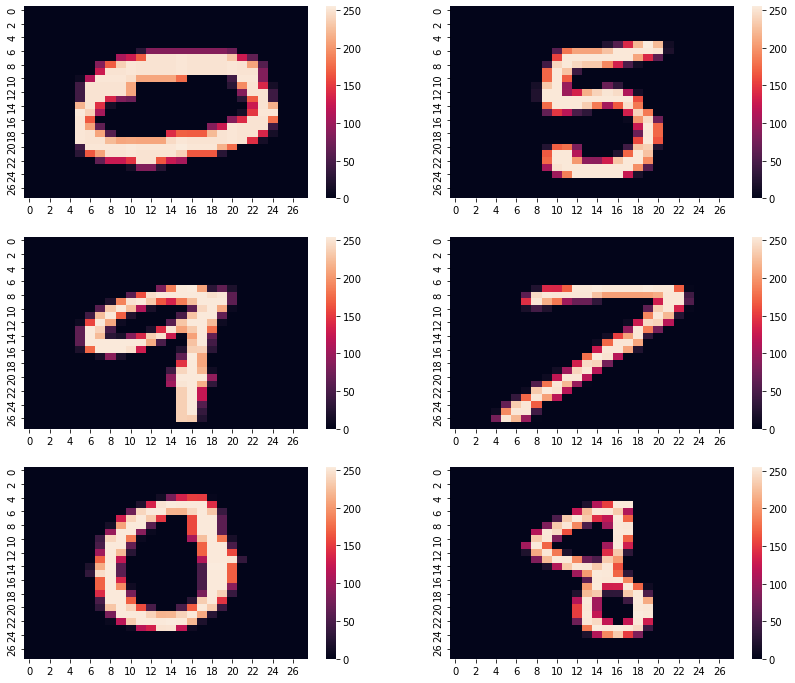

In [58]:
plt.figure(figsize=(14, 12))

pixels = test_dataNp[1].reshape(28, 28)
plt.subplot(321)
sns.heatmap(data=pixels)
test_sample = torch.FloatTensor(test_dataNp[1].tolist())
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

pixels = test_dataNp[10].reshape(28, 28)
plt.subplot(322)
sns.heatmap(data=pixels)
test_sample = torch.FloatTensor(test_dataNp[10].tolist())
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

pixels = test_dataNp[20].reshape(28, 28)
plt.subplot(323)
sns.heatmap(data=pixels)
test_sample = torch.FloatTensor(test_dataNp[20].tolist())
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

pixels = test_dataNp[30].reshape(28, 28)
plt.subplot(324)
sns.heatmap(data=pixels)
test_sample = torch.FloatTensor(test_dataNp[30].tolist())
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

pixels = test_dataNp[100].reshape(28, 28)
plt.subplot(325)
sns.heatmap(data=pixels)
test_sample = torch.FloatTensor(test_dataNp[100].tolist())
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

pixels = test_dataNp[2000].reshape(28, 28)
plt.subplot(326)
sns.heatmap(data=pixels)
test_sample = torch.FloatTensor(test_dataNp[1].tolist())
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)


print("Prediction: {} / {}".format(torch.max(net_out.data, 1)[1].numpy()[1], torch.max(net_out.data, 1)[1].numpy()[10]))
print("Prediction: {} / {}".format(torch.max(net_out.data, 1)[1].numpy()[20], torch.max(net_out.data, 1)[1].numpy()[30]))
print("Prediction: {} / {}".format(torch.max(net_out.data, 1)[1].numpy()[100], torch.max(net_out.data, 1)[1].numpy()[2000]))

In [59]:
output = (torch.max(net_out.data, 1)[1]).numpy()
#np.savetxt("out.csv", np.dstack((np.arange(1, output.size+1),output))[0],"%d,%d",header="ImageId,Label")

And that is about it, we've made a simple neural network using PyTorch that can recognize handwritten digits. Not so bad!

When I was writing this notebook, this model scorred 96.6%, which is not perfect by any means, but it's not that bad either. 

I hope this was useful for some of you. If you are totally new to deep learning, I suggest you learn how the neural networks actually work from the inside, especially the backpropagation algorithm.

These videos explain [neural nets](https://www.youtube.com/watch?v=aircAruvnKk&t=708s) and [backpropagation](https://www.youtube.com/watch?v=Ilg3gGewQ5U) quite well.

Also I suggest you to take a look at this [online book](http://neuralnetworksanddeeplearning.com/chap1.html) (it's absolutely free, btw), where neural networks are explained in great detail, and it even has an implementation of the MNIST problem from scratch, using only numpy.

If you have any feedback, feel free to leave comments down below, and good luck with your deep learning adventures :)

## Take-home exercise (50 points)

Make sure you can run the PyTorch examples of MNIST classification, then apply the PyTorch example to another
classification problem you've worked with this semester, the breast cancer dataset. Get familiar with
working with models in PyTorch, get the best result you can on the breast cancer dataset, then 
report your experiments and results in your brief lab report.

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("breast_cancer.csv")
print(data.columns)

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')


In [61]:
X = data.drop(columns=['id','Unnamed: 32','diagnosis'])
y = data['diagnosis']
y, unique_y = pd.factorize(y)
X_columns = X.columns

X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train)
y_test_tensor = torch.FloatTensor(y_test)
# y_train_tensor = torch.LongTensor(y_train)
# y_test_tensor = torch.LongTensor(y_test)

In [63]:
# Your code here

input_size = 30
output_size = 1
hidden1_size = 15
# hidden2_size = 5
#hidden3_size = None
#hidden4_size = None

epochs = 100
batch_size = 64
learning_rate = 0.005

In [64]:
class NNetwork(nn.Module):
    
    def __init__(self):
        super(NNetwork, self).__init__()
        # YOUR CODE HERE
        self.l1 = nn.Linear(input_size, hidden1_size)
        self.relu = nn.ReLU()
        self.l3 = nn.Linear(hidden1_size, output_size)
#         self.relu2 = nn.ReLU()
#         self.l5 = nn.Linear(hidden2_size, output_size)
        
        
    def forward(self, x):
        # YOUR CODE HERE
        x = self.l1(x)
        x = self.relu(x)
        x = self.l3(x)
        return F.sigmoid(x)
        #raise NotImplementedError()

In [65]:
# Continue yourself
net1 = NNetwork()
print(net1)

NNetwork(
  (l1): Linear(in_features=30, out_features=15, bias=True)
  (relu): ReLU()
  (l3): Linear(in_features=15, out_features=1, bias=True)
)


In [66]:
optimizer = optim.SGD(net1.parameters(), lr=learning_rate, momentum=0.9)
loss_func = nn.BCELoss() #binary cross entropy because only two classes

In [ ]:
y_var.reshape(-1,1)

In [74]:
loss_log = []
test_loss_log = []

for e in range(epochs):
    for i in range(0, X_train_tensor.shape[0], batch_size):
        x_mini = X_train_tensor[i:i + batch_size] 
        y_mini = y_train_tensor[i:i + batch_size] 
        
        x_var = Variable(x_mini)
        y_var = Variable(y_mini)
        
        x_test_var = Variable(X_test_tensor)
        y_test_var = Variable(y_test_tensor)
        
        optimizer.zero_grad()
        net_out = net1(x_var)
        
        loss = loss_func(net_out, y_var.reshape(-1,1))
        loss.backward()
        optimizer.step() 
        
        test_net_out = net1(x_test_var)
        test_loss = loss_func(test_net_out, y_test_var.reshape(-1,1))
        
        if i % 100 == 0:
            loss_log.append(loss.item())
            test_loss_log.append(test_loss.item())                 
                              
        
    print('Epoch: {} - Loss: {:.6f} -- test loss: {:.6f}'.format(e, loss.item(),test_loss.item()))

Epoch: 0 - Loss: 0.664086 -- test loss: 0.706667
Epoch: 1 - Loss: 0.590328 -- test loss: 0.632902
Epoch: 2 - Loss: 0.517348 -- test loss: 0.561440
Epoch: 3 - Loss: 0.450966 -- test loss: 0.494427
Epoch: 4 - Loss: 0.392301 -- test loss: 0.431592
Epoch: 5 - Loss: 0.342194 -- test loss: 0.374408
Epoch: 6 - Loss: 0.300038 -- test loss: 0.323238
Epoch: 7 - Loss: 0.264733 -- test loss: 0.278623
Epoch: 8 - Loss: 0.235072 -- test loss: 0.241273
Epoch: 9 - Loss: 0.210259 -- test loss: 0.211123
Epoch: 10 - Loss: 0.189818 -- test loss: 0.187280
Epoch: 11 - Loss: 0.172621 -- test loss: 0.168441
Epoch: 12 - Loss: 0.155986 -- test loss: 0.153361
Epoch: 13 - Loss: 0.141649 -- test loss: 0.141205
Epoch: 14 - Loss: 0.129209 -- test loss: 0.131153
Epoch: 15 - Loss: 0.118361 -- test loss: 0.122842
Epoch: 16 - Loss: 0.108819 -- test loss: 0.115858
Epoch: 17 - Loss: 0.100184 -- test loss: 0.109923
Epoch: 18 - Loss: 0.092477 -- test loss: 0.104816
Epoch: 19 - Loss: 0.085642 -- test loss: 0.100407
Epoch: 20 

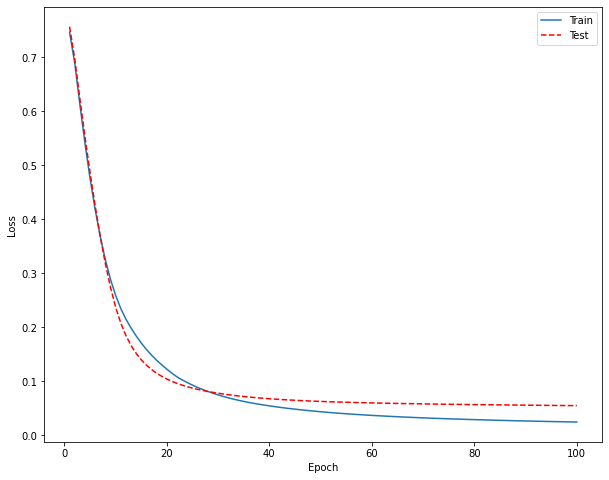

In [75]:
plt.figure(figsize=(10,8))
plt.plot(np.arange(1, epochs + 1, 1), loss_log, label='Train')
plt.plot(np.arange(1, epochs + 1, 1), test_loss_log,'r--', label='Test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [76]:
y_pred = net1(X_test_tensor)
y_pred = torch.round(y_pred)
y_pred.squeeze_()

tensor([1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
        1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
        1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0.,
        1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
        1., 1., 0., 1., 0., 0.], grad_fn=<SqueezeBackward2>)

In [77]:
acc = y_test[y_pred == y_test_tensor].shape[0]/ len(y_test) * 100
acc
print ('The test set accuracy is ', acc)

The test set accuracy is  98.24561403508771


The test set accuracy of the model created in Pytorch with  
input_size = 30,
output_size = 1,
hidden1_size = 15,
epochs = 100,
batch_size = 64,
learning_rate = 0.005,
is above 95 % on the breast cancer dataset which is very good. THis was achieved with only one hidden layer with 15 nodes and only 100 epochs. This shows how well a neural network can perform. OUr problem is binary i.e. only 1 and 0 classes so we used Binary Cross Entropy (BCE) as the loss functions and the SGD optimizer to get our results. The Training and test perform relatively similarly until we reach around the 30th epoch. So we could use the parameters from the 30th epoch to be our best fit for the model. 

